# Import Data and Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API Key
quandl.ApiConfig.api_key = '3Mv1uzqGr8k4nyGhX-_9'

In [3]:
# Importing the Federal Reserve Economic Data "Real Disposable Personal Income" variable.

data = quandl.get('FRED/DSPIC96')

In [4]:
data.head(5)

,Value
Date,
1959-01-01,2191.5
1959-02-01,2198.1
1959-03-01,2210.7
1959-04-01,2225.0
1959-05-01,2237.1


In [5]:
data.shape

(756, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

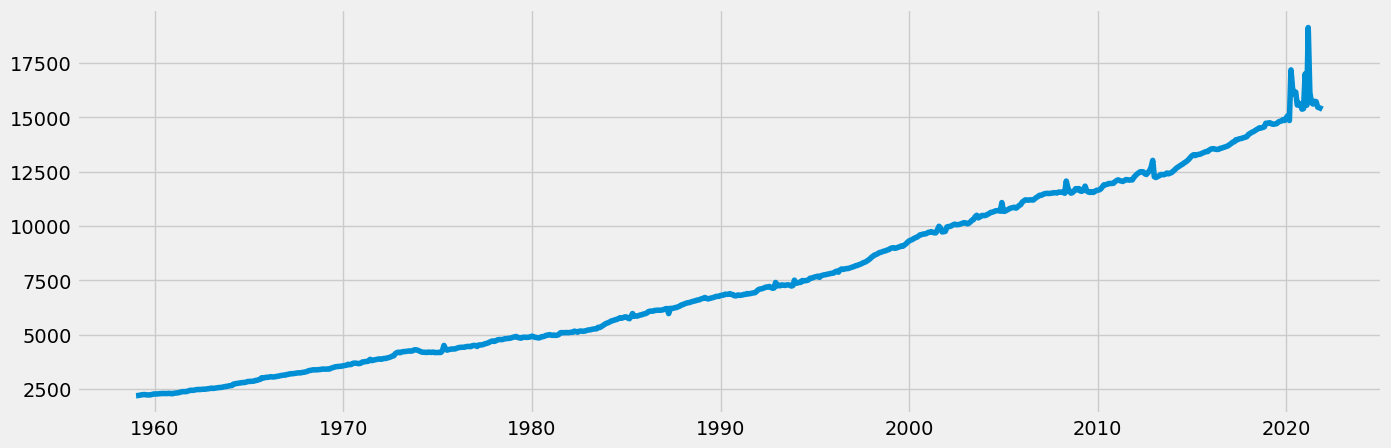

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1959-01-01,2191.5
1,1959-02-01,2198.1
2,1959-03-01,2210.7
3,1959-04-01,2225.0
4,1959-05-01,2237.1


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [13]:
data_sub.shape

(485, 2)

In [14]:
data_sub.head()

,Date,Value
252,1980-01-01,4930.4
253,1980-02-01,4904.0
254,1980-03-01,4873.2
255,1980-04-01,4867.9
256,1980-05-01,4850.1


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,4930.4
1980-02-01,4904.0
1980-03-01,4873.2
1980-04-01,4867.9
1980-05-01,4850.1


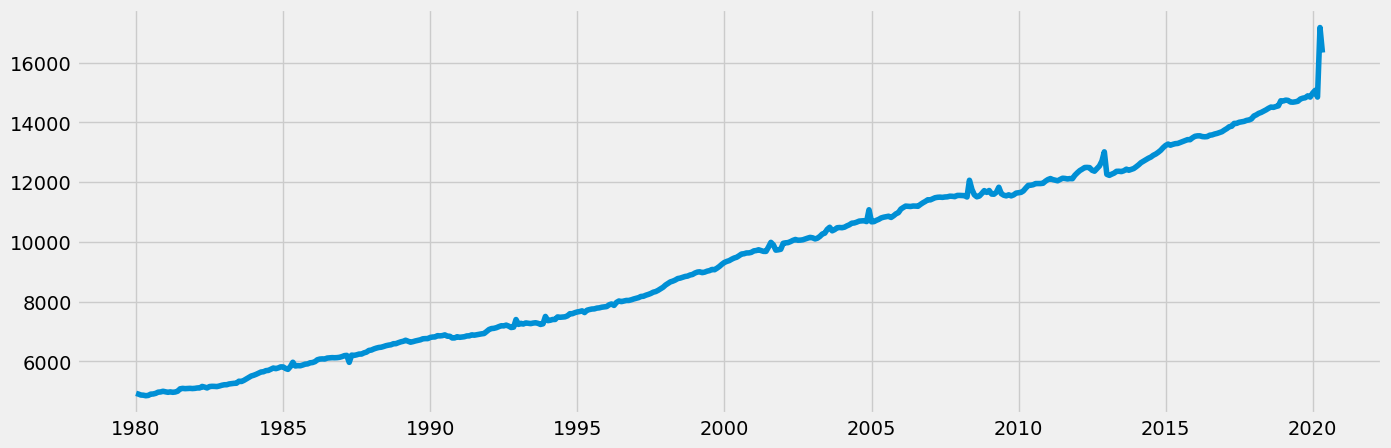

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values 

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


2

In [19]:
data_sub_clean = data_sub.drop_duplicates()

In [20]:
# Check for duplicates

dups = data_sub_clean.duplicated()
dups.sum()

# no dups

0

In [23]:
data_sub_clean.head()

,Value
datetime,
1980-01-01,4930.4
1980-02-01,4904.0
1980-03-01,4873.2
1980-04-01,4867.9
1980-05-01,4850.1


# Time Series Analysis: Decomposition

In [33]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [34]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

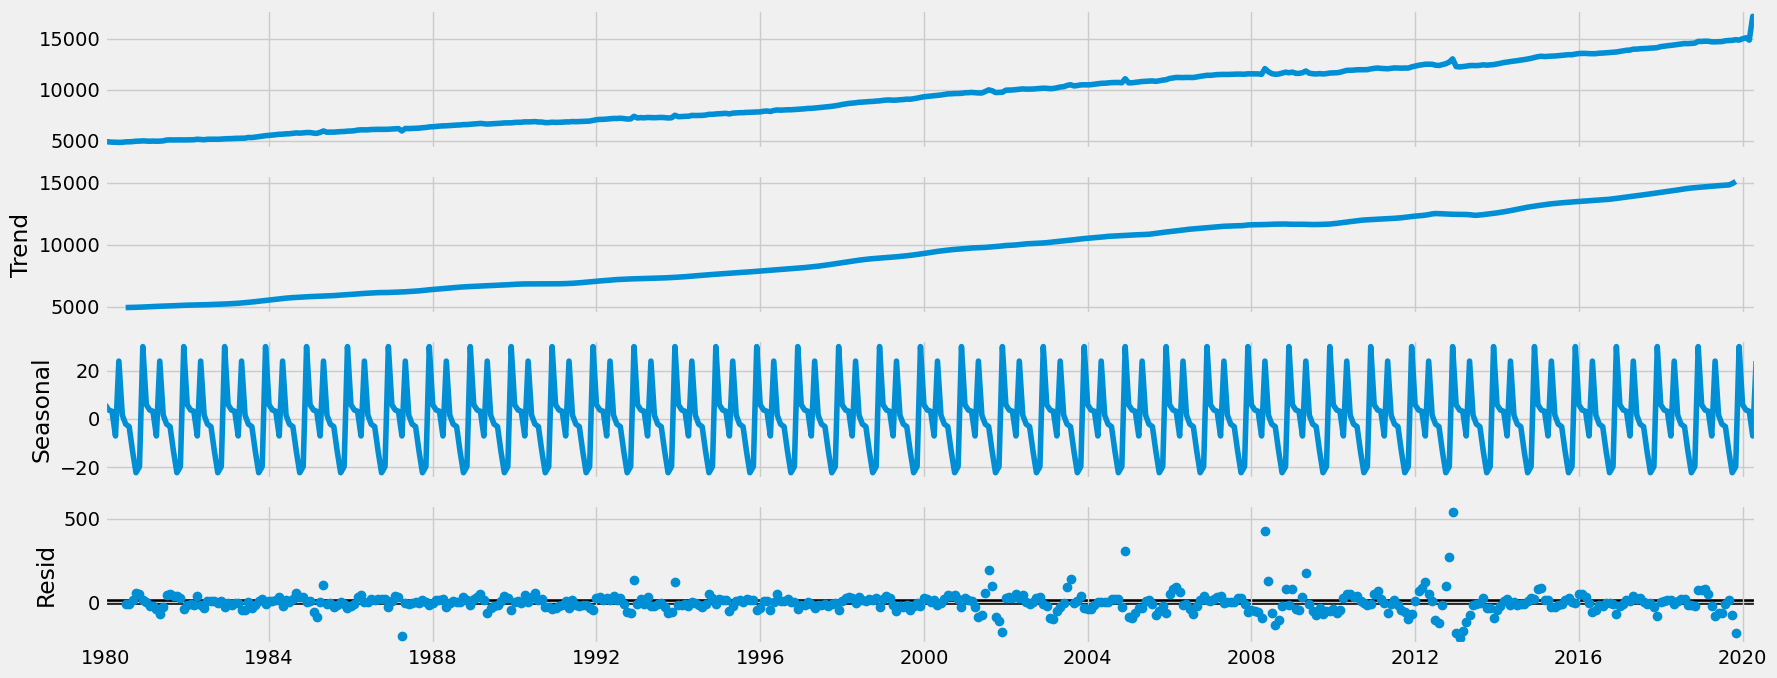

In [35]:
# Plot the separate components

decomposition.plot()
plt.show()

# Testing for Stationarity

In [36]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.726587
p-value                          0.999088
Number of Lags Used              4.000000
Number of Observations Used    480.000000
Critical Value (1%)             -3.444047
Critical Value (5%)             -2.867580
Critical Value (10%)            -2.569987
dtype: float64


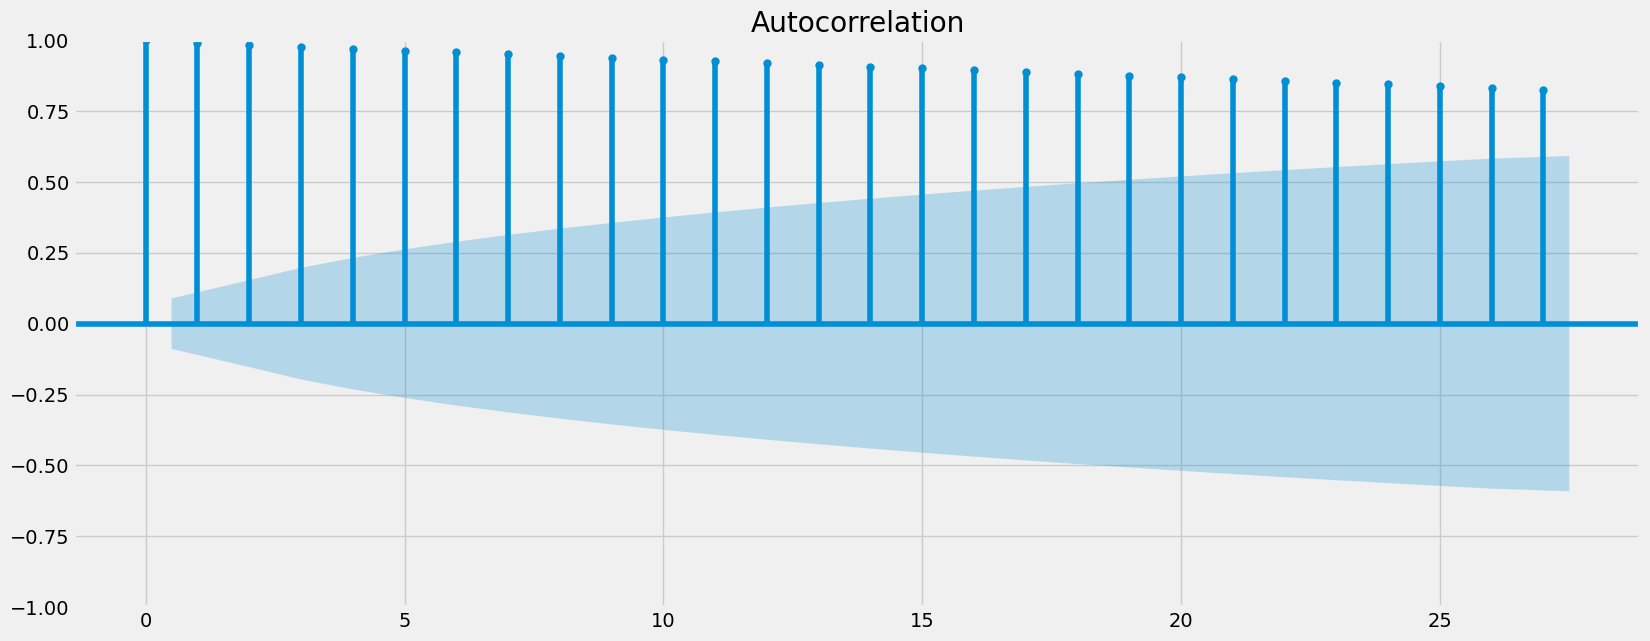

In [37]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Stationarizing the Federal Reserve Economic Data

In [38]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [39]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [40]:
data_diff.head()

,Value
datetime,
1980-02-01,-26.4
1980-03-01,-30.8
1980-04-01,-5.3
1980-05-01,-17.8
1980-06-01,10.5


In [41]:
data_diff.columns

Index(['Value'], dtype='object')

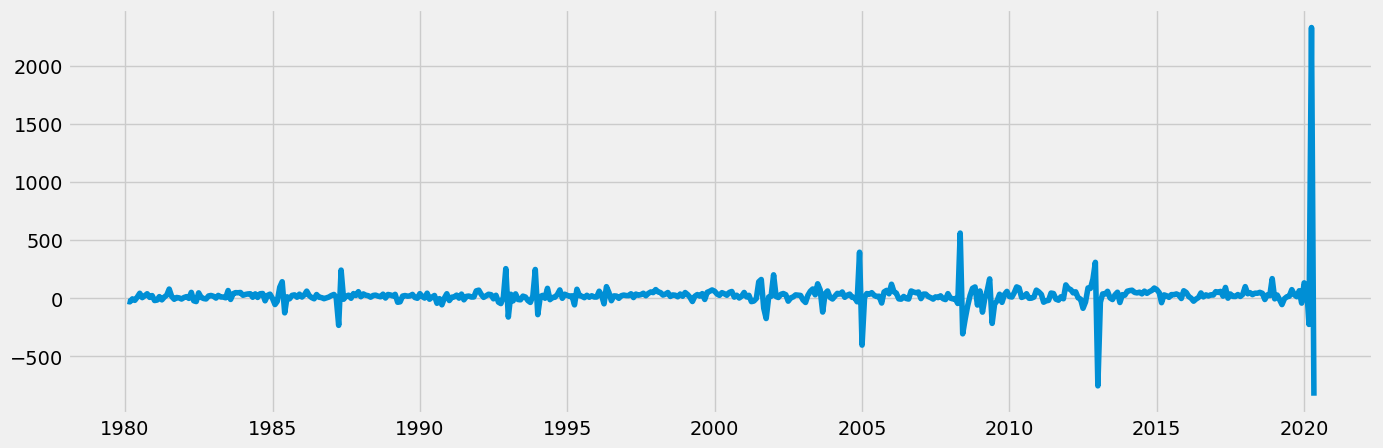

In [42]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [43]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.004007e+01
p-value                        1.504483e-17
Number of Lags Used            3.000000e+00
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


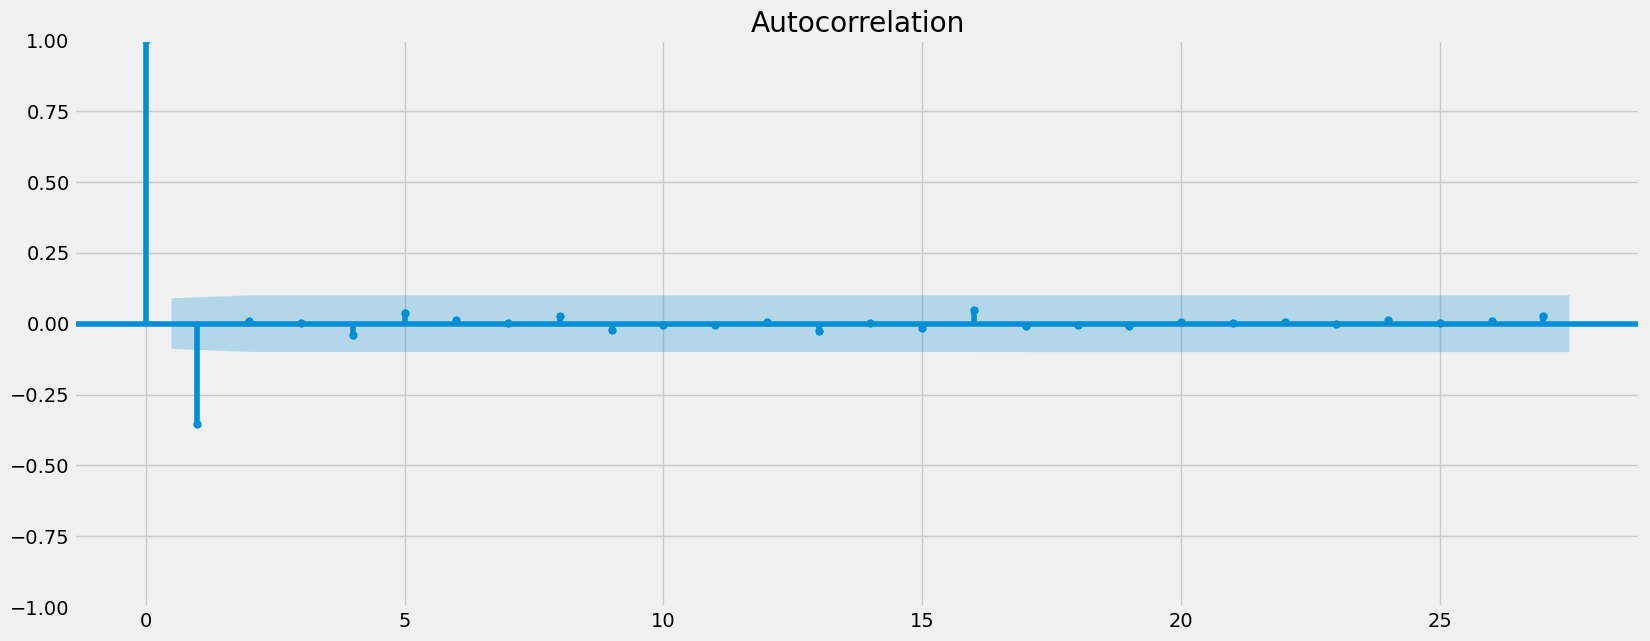

In [44]:
plot_acf(data_diff)
plt.show()

In [45]:
data_diff1 = data_sub - data_diff.shift(1)

In [46]:
data_diff1.dropna(inplace = True)

In [47]:
data_diff1.head()

,Value
datetime,
1980-03-01,4899.6
1980-04-01,4898.7
1980-05-01,4855.4
1980-06-01,4878.4
1980-07-01,4892.9
